[*********************100%***********************]  1 of 1 completed
c:\Users\berat\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\berat\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\berat\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\berat\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

Best ARIMA parameters: p=2, d=2, q=0 with MSE=25762161.81
                          Date  Predicted Price
2024-06-10 00:00:00 2024-10-20     69210.698957
2024-06-11 00:00:00 2024-10-21     69167.085767
2024-06-12 00:00:00 2024-10-22     68996.849920
2024-06-13 00:00:00 2024-10-23     68939.275872
2024-06-14 00:00:00 2024-10-24     68843.623433
2024-06-15 00:00:00 2024-10-25     68735.385005
2024-06-16 00:00:00 2024-10-26     68328.023438
Mean Squared Error (MSE): 8278689.64
Mean Absolute Error (MAE): 2074.71


c:\Users\berat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


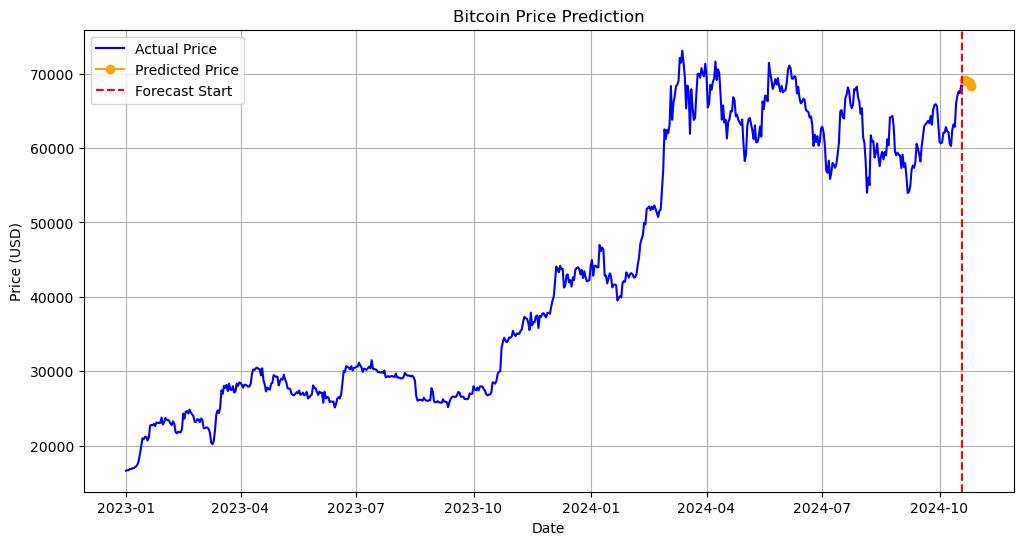

In [3]:
import yfinance as yf  # Import the yfinance library to fetch financial data
import pandas as pd  # Import pandas for data manipulation
import numpy as np  # Import numpy for numerical operations
from statsmodels.tsa.arima.model import ARIMA  # Import ARIMA model for time series analysis
from statsmodels.tsa.stattools import adfuller  # Import ADF test for stationarity check
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Import functions for model evaluation
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from datetime import datetime  # Import datetime for date manipulation

# Get today's date
end_date = datetime.now().strftime('%Y-%m-%d')  # Format current date as YYYY-MM-DD

# Download Bitcoin data
btc_data = yf.download('BTC-USD', start='2023-01-01', end=end_date)  # Fetch Bitcoin data from Yahoo Finance

# Use only the 'Close' prices
btc_data = btc_data['Close'].asfreq('D')  # Extract the closing prices and set frequency to daily

# Check for stationarity using ADF test
adf_result = adfuller(btc_data)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] > 0.05:
    print("Series is non-stationary. Differencing is required.")
    btc_data = btc_data.diff().dropna()  # Apply differencing if series is non-stationary

# Split data into training and test sets
train_size = int(len(btc_data) * 0.8)  # Calculate the size of the training set (80%)
train, test = btc_data[0:train_size], btc_data[train_size:]  # Split the data into train and test sets

# Find the best ARIMA parameters
best_mse = float("inf")  # Initialize the best mean squared error as infinity
best_order = None  # Initialize the best ARIMA order as None

for p in range(3):  # Iterate over possible values of p (0 to 2)
    for d in range(1):  # Use d=1 for differencing
        for q in range(3):  # Iterate over possible values of q (0 to 2)
            try:
                model = ARIMA(train, order=(p, d, q), start_params=[0.1] * (p + q + 1))  # Create an ARIMA model with parameters (p, d, q)
                model_fit = model.fit(method='bfgs')  # Fit the model to the training data with a different method
                predictions = model_fit.forecast(steps=len(test))  # Forecast the values for the test set
                
                mse = mean_squared_error(test, predictions)  # Calculate the mean squared error
                if mse < best_mse:  # If the current MSE is better than the best found
                    best_mse = mse  # Update the best MSE
                    best_order = (p, d, q)  # Update the best parameters
            except Exception as e:
                print(f"Error for order (p={p}, d={d}, q={q}): {e}")  # Print any errors

# Print the best parameters and MSE
if best_order is not None:
    print(f'Best ARIMA parameters: p={best_order[0]}, d={best_order[1]}, q={best_order[2]} with MSE={best_mse:.2f}')  # Output the best parameters and MSE

    # Fit the best model and forecast
    best_model = ARIMA(train, order=best_order)  # Create the best ARIMA model with the best parameters
    best_model_fit = best_model.fit()  # Fit the best model to the training data
    forecast = best_model_fit.forecast(steps=7)  # Forecast the next 7 days

    # Last closing price
    last_close = btc_data.iloc[-1]  # Get the last closing price from the dataset

    # Store the last close price and predicted prices in a DataFrame
    predicted_prices = pd.DataFrame({
        'Date': pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=7),  # Generate dates for predictions
        'Predicted Price': forecast  # Add the forecasted prices
    })

    # Set the first prediction as the last closing price
    predicted_prices.loc[0, 'Predicted Price'] = last_close  # First prediction is set to the last closing price
    predicted_prices['Predicted Price'] = predicted_prices['Predicted Price'].shift(-1)  # Shift the predictions up by one

    # Drop NaN values
    predicted_prices = predicted_prices.dropna()  # Remove any rows with NaN values

    # Calculate MSE and MAE
    mse = mean_squared_error(test[-len(predicted_prices):], predicted_prices['Predicted Price'])  # Calculate MSE for predictions
    mae = mean_absolute_error(test[-len(predicted_prices):], predicted_prices['Predicted Price'])  # Calculate MAE for predictions

    print(predicted_prices)  # Print the DataFrame with predicted prices
    print(f'Mean Squared Error (MSE): {mse:.2f}')  # Output the MSE
    print(f'Mean Absolute Error (MAE): {mae:.2f}')  # Output the MAE

    # Visualize results
    plt.figure(figsize=(12, 6))  # Set the figure size for the plot
    plt.plot(btc_data.index, btc_data, label='Actual Price', color='blue')  # Plot actual prices in blue
    plt.plot(predicted_prices['Date'], predicted_prices['Predicted Price'], label='Predicted Price', color='orange', marker='o')  # Plot predicted prices in orange
    plt.axvline(x=test.index[-1], color='red', linestyle='--', label='Forecast Start')  # Draw a vertical line for forecast start
    plt.title('Bitcoin Price Prediction')  # Set the title of the plot
    plt.xlabel('Date')  # Set the x-axis label
    plt.ylabel('Price (USD)')  # Set the y-axis label
    plt.legend()  # Show the legend
    plt.grid()  # Add a grid to the plot
    plt.show()  # Display the plot
else:
    print("No valid ARIMA order was found.")
